In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
!{sys.executable} -m pip install xgboost
import xgboost as xgb
from sklearn.metrics import mean_squared_error
col_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

## 1. read the uploaded excel

In [57]:
df = pd.concat(pd.read_excel('./sales_data_latest.xlsx', sheet_name=None), ignore_index=True)
df.head()

,Order ID,Product ID,Customer ID,Product,Brand,Sale Date,Unit Price,Quantity,Total Price,Special Day
0,OID-163598,PID-777772,CID-050304,SSD,Lenovo,01/01/2017,6509.67,1,6509.67,True
1,OID-401233,PID-170003,CID-517488,Cooler,HP,01/01/2017,4119.34,6,24716.04,True
2,OID-353114,PID-315876,CID-149443,SSD,Microsoft,01/01/2017,7205.64,14,100878.96,True
3,OID-339307,PID-595717,CID-879783,Mouse,Lenovo,01/01/2017,341.77,21,7177.17,True
4,OID-235964,PID-220316,CID-323475,Cooler,BoAt,01/01/2017,3837.97,30,115139.10,True


In [58]:
df = df.set_index('Sale Date')

In [59]:
df.index = pd.to_datetime(df.index, infer_datetime_format=True)

/Users/Nryn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1056: UserWarning: Parsing '13/01/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/Nryn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1056: UserWarning: Parsing '13/02/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/Nryn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1056: UserWarning: Parsing '13/03/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/Nryn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1056: UserWarning: Parsing '13/04/2017' in

In [60]:
## Just checking for a single product. 
df = df[df.Product == 'Monitor']
df.head()

,Order ID,Product ID,Customer ID,Product,Brand,Unit Price,Quantity,Total Price,Special Day
Sale Date,,,,,,,,,
2017-01-01,OID-714754,PID-534823,CID-004259,Monitor,HP,12863.34,26,334446.84,True
2017-01-01,OID-061472,PID-720664,CID-433885,Monitor,Microsoft,15476.00,19,294044.00,True
2017-01-01,OID-720487,PID-807677,CID-601065,Monitor,Apple,10211.00,19,194009.00,True
2017-01-01,OID-177392,PID-438110,CID-504950,Monitor,Apple,13846.83,18,249242.94,True
2017-01-01,OID-580967,PID-795676,CID-809742,Monitor,BoAt,12482.87,29,362003.23,True


<AxesSubplot:title={'center':'Initial data preview'}, xlabel='Sale Date'>

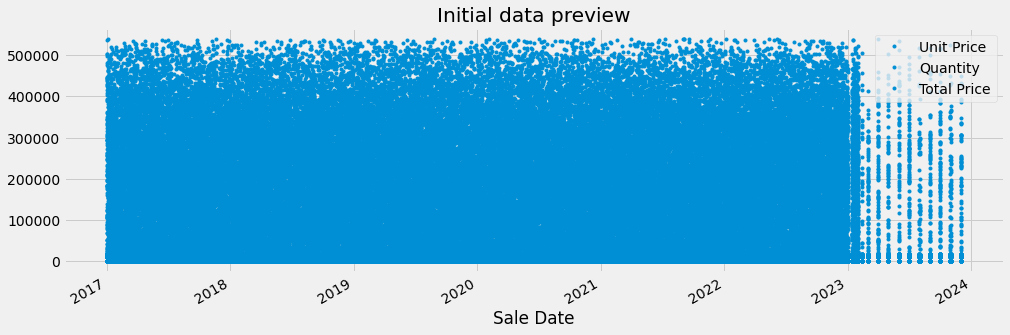

In [61]:
df.plot(style='.', figsize=(15,5), color=col_palette[0], title='Initial data preview')

## 2. Train Split

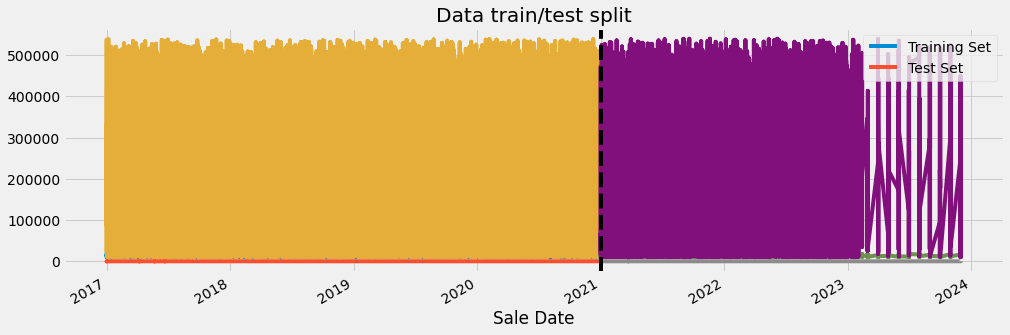

In [62]:

train = df.loc[df.index < '01-01-2021']
test = df.loc[df.index >= '01-01-2021']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax =ax, label='Training Set', title='Data train/test split')
test.plot(ax= ax, label='Test Set')
ax.axvline('01-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<AxesSubplot:xlabel='Sale Date'>

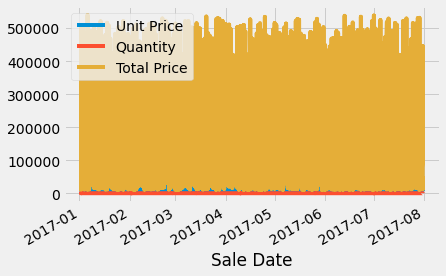

In [63]:
df.loc[(df.index > '01-01-2017') & (df.index < '08-01-2017')].plot()

## Feature Creation

In [64]:
def create_features(df):
    """
    Create time series features based on time series index 
    """
    df = df.copy()
    df['dayofweek']=df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['dayofyear']  = df.index.day_of_year
    df['year'] = df.index.year
    return df
df = create_features(df)

In [65]:
df.columns

Index(['Order ID', 'Product ID', 'Customer ID', 'Product', 'Brand',
       'Unit Price', 'Quantity', 'Total Price', 'Special Day', 'dayofweek',
       'quarter', 'month', 'dayofyear', 'year'],
      dtype='object')

## Visualize Feature / Target relationship

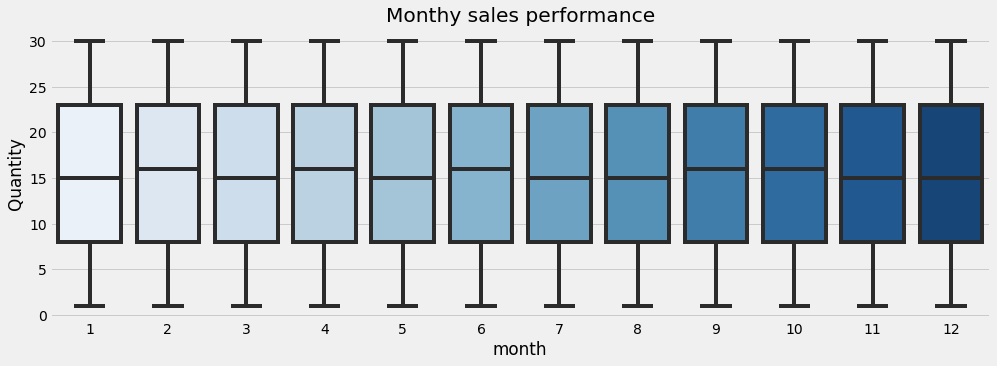

In [66]:

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='month', y='Quantity', palette = 'Blues')
ax.set_title('Monthy sales performance')
plt.show()

In [67]:
## creating features for training and testing datasets
train = create_features(train)
test = create_features(test)

# train['Special Day'] = pd.to_datetime(train['Special Day'], infer_datetime_format=True)
# test['Special Day'] = pd.to_datetime(test['Special Day'], infer_datetime_format=True)
FEATURES = ['dayofweek', 'quarter', 'month', 'dayofyear', 'year', 'Special Day']
TARGET = 'Quantity'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

## Model Creation 

In [68]:
reg = xgb.XGBRegressor(n_estimators=500, early_stopping_rounds = 50)
reg.fit(X_train, y_train, 
        eval_set=[(X_train, y_train),(X_test, y_test)], 
        verbose=True)

[0]	validation_0-rmse:13.58946	validation_1-rmse:13.65754
[1]	validation_0-rmse:11.34709	validation_1-rmse:11.40274
[2]	validation_0-rmse:10.06487	validation_1-rmse:10.11277
[3]	validation_0-rmse:9.36926	validation_1-rmse:9.40792
[4]	validation_0-rmse:9.00863	validation_1-rmse:9.04172
[5]	validation_0-rmse:8.82491	validation_1-rmse:8.85290
[6]	validation_0-rmse:8.73032	validation_1-rmse:8.75854
[7]	validation_0-rmse:8.68421	validation_1-rmse:8.71148
[8]	validation_0-rmse:8.66179	validation_1-rmse:8.68725
[9]	validation_0-rmse:8.64791	validation_1-rmse:8.67480
[10]	validation_0-rmse:8.64079	validation_1-rmse:8.66858
[11]	validation_0-rmse:8.63707	validation_1-rmse:8.66657
[12]	validation_0-rmse:8.63314	validation_1-rmse:8.66450
[13]	validation_0-rmse:8.63223	validation_1-rmse:8.66434
[14]	validation_0-rmse:8.62953	validation_1-rmse:8.66424
[15]	validation_0-rmse:8.62744	validation_1-rmse:8.66403
[16]	validation_0-rmse:8.62426	validation_1-rmse:8.66413
[17]	validation_0-rmse:8.62208	vali

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature importances for selection

<AxesSubplot:title={'center':'Feature importance'}>

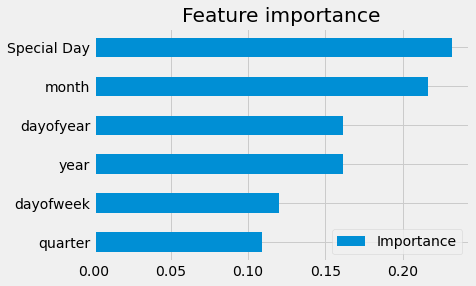

In [69]:
fi = pd.DataFrame(data = reg.feature_importances_, 
             index = reg.feature_names_in_,
             columns = ['Importance'])
fi.sort_values('Importance').plot(kind= 'barh', title='Feature importance')

## Forecasting...

In [70]:
test['Prediction'] = reg.predict(X_test)

In [71]:
df = df.merge(test['Prediction'], how='left', left_index=True, right_index=True)

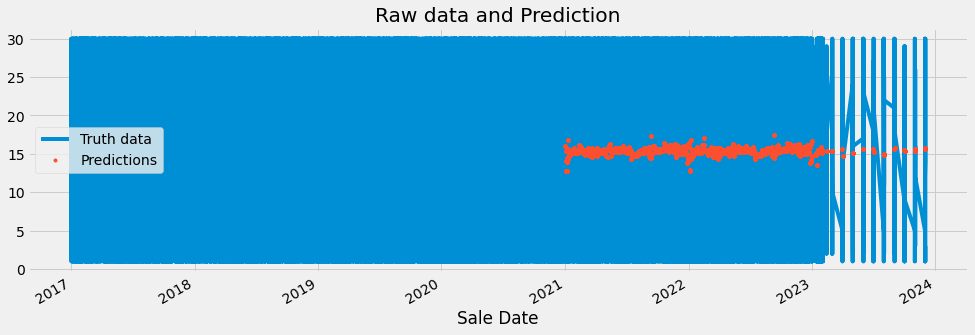

In [72]:
ax = df[['Quantity']].plot(figsize=(15,5))
df['Prediction'].plot(ax = ax, style='.')
plt.legend(['Truth data', 'Predictions'])
ax.set_title('Raw data and Prediction')
plt.show()

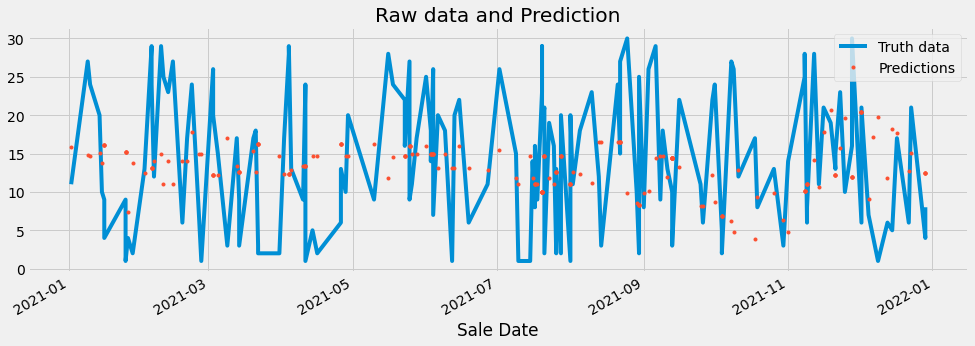

In [47]:
ax = df.loc[(df.index > '01-01-2021') & (df.index < '01-01-2022')]['Quantity'].plot(figsize=(15,5), title='week data')
df.loc[(df.index > '01-01-2021') & (df.index < '01-01-2022')]['Prediction'].plot(style='.')
plt.legend(['Truth data', 'Predictions'])
ax.set_title('Raw data and Prediction')
plt.show()


In [73]:
# Saving the model to disk
reg.save_model('xg_model_v2.json')

In [74]:
# to see the size of the model on the disk
!ls -lh

total 135424
-rw-r--r--  1 Nryn  staff   853B May  7 15:23 Learning_lab.ipynb
-rw-r--r--  1 Nryn  staff    15K May 15 02:33 Pandas_1.ipynb
-rw-r--r--@ 1 Nryn  staff   1.8M Apr 23 22:31 Peripheral Sales Data.xlsx
-rw-r--r--@ 1 Nryn  staff    74K Jun 19 16:34 data_gen.ipynb
-rw-r--r--  1 Nryn  staff   6.0K Jun 19 14:22 data_gen_v2.ipynb
-rw-r--r--@ 1 Nryn  staff    16K Jun 12 15:08 existing_data.csv
-rw-r--r--@ 1 Nryn  staff    52K Jun 13 22:50 existing_data_v2.csv
-rw-r--r--  1 Nryn  staff   215K Jun 19 14:20 orders_2.xlsx
-rw-r--r--  1 Nryn  staff   297K Jun 19 14:20 orders_v4.csv
-rw-r--r--  1 Nryn  staff   424K Jun 19 16:16 reatail_forecasting.ipynb
-rw-r--r--  1 Nryn  staff   891K Jun 19 17:04 reatail_forecasting_latest.ipynb
-rw-r--r--@ 1 Nryn  staff    62M Jun 19 16:55 sales_data_latest.xlsx
-rw-r--r--  1 Nryn  staff   243K Jun 13 19:00 xg_model_v1.json
-rw-r--r--  1 Nryn  staff   309K Jun 19 17:06 xg_model_v2.json


In [125]:
# To load the trained model from local..
reg_v2 = xgb.XGBRFRegressor()
reg_v2.load_model('xg_model_v1.json')
